# CT 복원영상에서 폐, 기도, 심장을 가이드해주는 딥러닝 모델 만들기

## 1. CT이미지 데이터셋 살펴보기

In [1]:
import os
import pandas as pd

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# data_dir = "../DATASET/Segmentation/"
data_dir = r"C:\Users\com\MEDICAL-DATASET-002\Segmentation"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [4]:
def extract_client_id(x):
    return x.split("_")[0]

In [5]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_client_id(x))
data_df

,ImageId,MaskId,Id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [6]:
import numpy as np

In [7]:
client_ids = np.unique(data_df.Id.values)
print(len(client_ids))  ## 총 임상 참여자(또는 환자)의 수는 112명 

112


In [8]:
index = 0
client_data = data_df[data_df.Id == client_ids[index]][["ImageId", "MaskId"]]
client_data  ## 0번째 환자의 훈련이미지와 타겟이미지

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg
5,ID00007637202177411956430_5.jpg,ID00007637202177411956430_mask_5.jpg
6,ID00007637202177411956430_6.jpg,ID00007637202177411956430_mask_6.jpg
7,ID00007637202177411956430_7.jpg,ID00007637202177411956430_mask_7.jpg
8,ID00007637202177411956430_8.jpg,ID00007637202177411956430_mask_8.jpg
9,ID00007637202177411956430_9.jpg,ID00007637202177411956430_mask_9.jpg


In [9]:
import cv2
import matplotlib.pyplot as plt

sub_index = 15   ## index로 뽑힌 client 데이터에서 다시 index로 지정함 sub index
img_name, mask_name = client_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

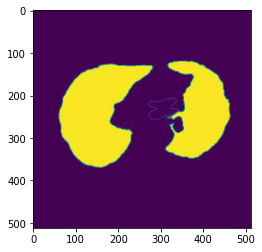

In [10]:
plt.imshow(mask[:,:,0])  ## mask의 데이터셋에서 channel은 RGB가 아니라, 폐 / 심장 / 기도 순서임

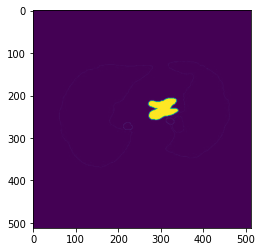

In [11]:
plt.imshow(mask[:,:,1])   ## 심장의 사진 

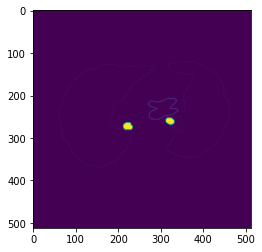

In [12]:
plt.imshow(mask[:,:,2])

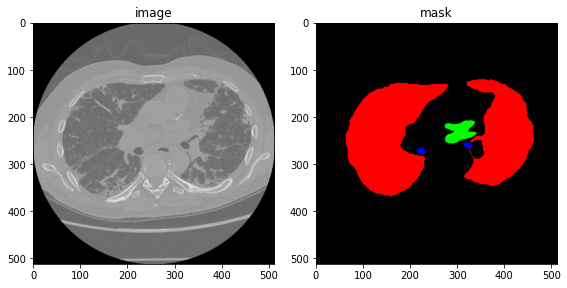

In [13]:
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [14]:
np.unique(image)

array([  0,   1,   2,   3,   4,   5,   6,   7,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 252], dtype=uint8)

In [15]:
def get_client_data(data_df, index):  ## INDEX는 환자 INDEX
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[index]
    client_data = data_df[data_df.Id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [16]:
 ## 배경은 검정색, 기도는 파랑, 심장은 초록, 폐는 빨강으로 설정  (OPENCV의 컬러 스페이스는 BGR임)

regions = ["background", "trachea", "heart", "lung"]  
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255))



In [17]:
index = 0
client_id, image_files, mask_files = get_client_data(data_df, index)  ## 환자의 INDEX를 입력하여, 이미지/마스크 파일 출력

## 이미지를 통해 영상만들기 (환자별)
canvas = np.zeros(shape=(512, 2*512+50, 3), dtype=np.uint8)
for i in range(len(image_files)):
    image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255
    grid_pad = 50
    
    canvas[:, :512, :] = image
    canvas[:, 512+grid_pad:2*512+grid_pad, :] = mask
    
    text_buff = 410
    for j in range(1, len(regions)):
        cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40
    
    cv2.imshow('CT frames', canvas)
    key = cv2.waitKey(60)
    if key == 27:
        break
cv2.destroyAllWindows()

## 2. 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [18]:
import torch

np.expand_dims 사용법 (https://webnautes.tistory.com/1529)


Numpy 배열의 차원을 추가하는 함수

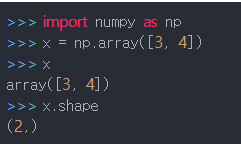


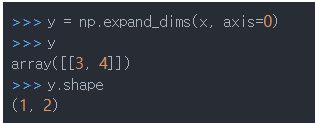


np.expand_dims(background, -1) 은 2차원의 background numpy를 3차원으로 변경

In [19]:
background = np.ones(shape=(25, 25))
np.expand_dims(background, -1).shape

(25, 25, 1)

np.concatenate에 대한 이해  : Numpy 배열들을 하나로 합치는데 이용됨.

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221490583222

In [20]:
import numpy as np

a = np.array([[1, 2], [3, 4], [5, 6]])
b = np.array([[7, 8], [9, 10], [11, 12]])

print(np.concatenate([a, b], axis=0))
print(np.concatenate((a, b), axis=1))
print(np.concatenate((a, b), axis=None))
print(np.concatenate([a, b], axis= -1))

[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
[[ 1  2  7  8]
 [ 3  4  9 10]
 [ 5  6 11 12]]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[[ 1  2  7  8]
 [ 3  4  9 10]
 [ 5  6 11 12]]


In [21]:
# dataset 만드는 함수

class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):   # phase : train 모드인지, test 모드인지, transformer: from torchvision import transforms 적용에 대한 메소드 
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]
        assert len(self.image_files) == len(self.mask_files)  ## 둘의 데이터 크기가 다르면, AssertionError 발생
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)  ## 데이터가 512x 512 파일이므로, 보통의 U-net의 이미지 사이즈 (224 x 224)에 맞추는 코드
                                                                                                ## 학습데이터는 선형 interpolation으로 진행함
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)## 데이터가 512x 512 파일이므로, 보통의 U-net의 이미지 사이즈 (224 x 224)에 맞추는 코드
                                                                                                ## 마스킹 데이터는 경계구분이 분명해야하므로 cv2.INTER_NEAREST로 interpolation 진행
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255
        
        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[...,0] != 0] = 0            ## 기도가 아닌 부분을 background로 설정 (값을 0으로)
        background[mask[...,1] != 0] = 0            ## 심장이 아닌 부분을 background로 설정
        background[mask[...,2] != 0] = 0            ## 폐가 아닌 부분을 background로 설정
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1) ##  background 이미지를 mask 이미치 채널에 추가 (이제 4채널임)
                                                                                ## background 도 학습의 대상이므로, mask 데이터에 필요
        mask = np.argmax(mask, axis=-1) ## mask를 4채널 중에 가장 높은 값을 갖는 class로 표현함 (0: 기도, 1: 심장, 2: 폐, 3: 배경)                
        
        if self.transformer:
            image = self.transformer(image)  # 이미지에 대해 tensor 변형을 적용함
            
        target = torch.from_numpy(mask).long() # 마스크에 대해서도 텐서로 변환한후, 픽셀 단위로 classification을 하기 위해 정수형으로 변경
        return image, target

In [22]:
mask.shape

(512, 512, 3)

In [23]:
IMAGE_SIZE = 224  ## 보통의 U-net의 이미지 사이즈 (224 x 224)

transforms.ToTensor() 의 의미 : 0 ~ 255의 값을 0.0~1.0으로 변경

Init signature: transforms.ToTensor()
Docstring:     
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor. This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
or if the numpy.ndarray has dtype = np.uint8

In [24]:
from torchvision import transforms
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),    
        transforms.Normalize(mean =[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  ## imagenet에서의 RGB space의 평균, 표준편차를 적용
    ])
    return transformer

# Collate_fn

dataset이 고정된 길이가 아닐 경우, batchsize를 2 이상으로 dataloader를 호출하면 dataloader에서 batch로 바로 못묶이고 에러가 난다. 따라서 텍스트데이터와 같이 variable length data를 다루고 batchsize를 2 이상으로 주고자 하는 경우에는 collate_fn 함수를 직접 작성해 넘겨주어야 한다.

사용예시 : 
 dataloaders["train"] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

https://velog.io/@jiyoung/torch-collatefn%EC%97%90-arguments-%EC%B6%94%EA%B0%80%ED%95%98%EA%B8%B0

In [25]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch: 
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0) 
    targets = torch.stack(targets, dim=0)

    return images, targets

## torch.stack   /  torch.cat

 torch.cat()은 주어진 차원을 기준으로 주어진 텐서들을 붙입(concatenate)니다. 
 torch.stack()은 새로운 차원으로 주어진 텐서들을 붙입니다. 
 
 따라서, (3, 4)의 크기(shape)를 갖는 2개의 텐서 A와 B를 붙이는 경우, 
 
 torch.cat([A, B], dim=0)의 결과는 (6, 4)의 크기(shape)를 갖고, torch.stack([A, B], dim=0)의 결과는 (2, 3, 4)의 크기를 갖습니다. 

In [26]:
from torch.utils.data import DataLoader

In [27]:
data_dir = r"C:\Users\com\MEDICAL-DATASET-002\Segmentation"
transformer = build_transformer()
dset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)

image, target = dset[0]
print(f"image shape: {image.shape}")
print(f"target shape: {target.shape}")

image shape: torch.Size([3, 224, 224])
target shape: torch.Size([224, 224])


In [28]:
data_dir = r"C:\Users\com\MEDICAL-DATASET-002\Segmentation"
transformer = build_transformer()
tr_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [29]:
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()
    
    dataloaders = {}
    train_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)  
    # 데이터SET끼리의 길이가 같으므로, collate_fn 없어도 결과는 동일

    val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn) 
    # 데이터SET끼리의 길이가 같으므로, collate_fn 없어도 결과는 동일

    return dataloaders

In [30]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"masks shape: {targets.shape}")
    if index == 0:
        break

images shape: torch.Size([4, 3, 224, 224])
masks shape: torch.Size([4, 224, 224])


## 3. U-Net 데이터 아키텍처 구현해보기

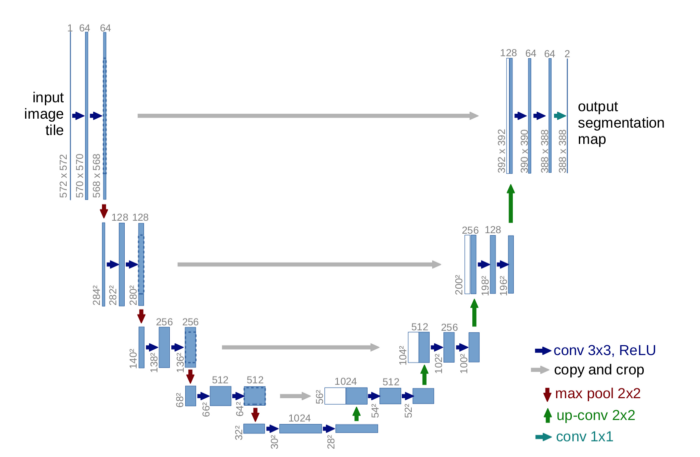
그림 출처: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

In [31]:
import torch
import torch.nn as nn

In [32]:
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),  ## inplace 하면 input으로 들어온 것 자체를 수정하겠다는 뜻. 
                                 ## 메모리 usage가 좀 좋아짐. 하지만 input을 없앰.
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        encode_features = []        ## SKIP CONNECTION에 쓰일 FEATURE들을 저장해놓을 리스트
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block5(out)
        return out, encode_features

In [34]:
# 테스트 겸 ENCODER 모델 실행해보기
encoder = Encoder()
x = torch.randn(1, 3, 224, 224)   ## X에 224 X 224 사이즈로 아무 데이터 넣어서 실행해보기
out, ftrs = encoder(x)
out, ftrs

(tensor([[[[4.7999e-01, 7.4357e-01, 4.2502e-02,  ..., 1.5479e-01,
            5.9154e-01, 5.6142e-01],
           [9.6679e-04, 3.9478e-02, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 2.3865e+00, 9.0440e-01,  ..., 1.0496e+00,
            6.5358e-01, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 5.8506e-01,  ..., 1.5407e+00,
            1.0176e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 1.4151e+00,  ..., 1.2461e+00,
            0.0000e+00, 2.6039e-01],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4807e-02,
            0.0000e+00, 0.0000e+00]],
 
          [[0.0000e+00, 5.9433e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 2.5717e-01],
           [0.0000e+00, 1.1394e+00, 7.8383e-01,  ..., 1.1720e+00,
            0.0000e+00, 1.6817e+00],
           [3.2914e-01, 0.0000e+00, 0.0000e+00,  ..., 1.1027e-01,
            0.0000e+00, 3.6251e-01],
           ...,
           [8.0907e-02, 1.9424e+00, 0.

In [35]:
for ftr in ftrs:
    print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [36]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [37]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)  ## ENCODER의 역순으로 진행
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)   ## Skip connection Size + 직전 단계의 output Size
        
        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)
        
        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)
        
        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)
        
    def forward(self, x, encoder_features):  ##   encoder_features   :  skip connection용 feature
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:]) # encoder_features[-1] : 가장 최근의 feature를 불러옴
        out = torch.cat([out, croped_enc_feature], dim=1)  ## (Batch, Channel(Filter), Height, Width) dim = 1은 channel 차원에 대해 concat을 의미 
        out = self.conv_block1(out)
        
        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)
        
        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)
        
        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out
        
    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [38]:
## UNET 테스트로 임의 입력값 집어넣기

encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [39]:
##  1, 3, 224, 224 사이즈 입력헀을때의 출력 사이즈는  torch.Size([1, 64, 224, 224]
    
print(out.shape)   

torch.Size([1, 64, 224, 224])


In [40]:
import torch.nn.functional as F

In [41]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)         ## pointwise convolution 실행  (64채널에서 4채널로 압축)
        self.retain_input_dim = retain_input_dim
        
    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [42]:
model = UNet(num_classes=4)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 4, 224, 224])


## 4. Dice similarity coefficient 설명 및 구현하기

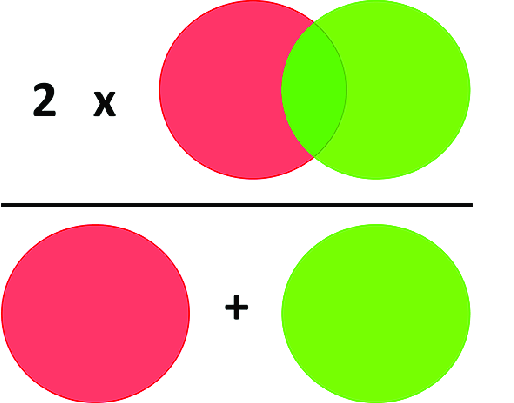
그림 출처: https://www.researchgate.net/figure/Scheme-to-explain-how-Dice-coefficient-is-calculated-The-light-red-and-light-green_fig4_352895635

### Dice similarity coefficient(DSC) == F1 score? YES only if binary segmentation task!

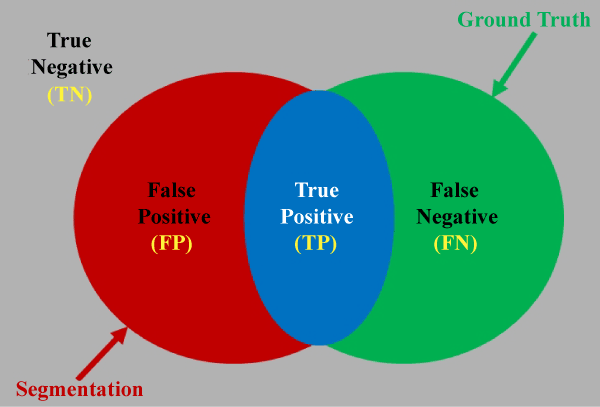
그림 출처: https://www.omicsonline.org/articles-images/JCSB-07-209-g003.html

### What is Dice coefficient loss or Dice loss? Dice loss = 1 - DSC

In [43]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    print(predictions.shape)
    if index == 0:
        break

torch.Size([4, 4, 224, 224])


In [44]:
num_classes = 4

predictions_ = torch.argmax(predictions, dim=1)  ## Channel(Class)을 기준으로 가장 높은 확률을 갖는 Class로 segmentation class 지정
print(predictions_)

tensor([[[3, 0, 3,  ..., 3, 3, 1],
         [1, 3, 1,  ..., 1, 1, 0],
         [1, 1, 0,  ..., 1, 1, 0],
         ...,
         [0, 0, 0,  ..., 2, 1, 0],
         [1, 3, 0,  ..., 0, 1, 0],
         [0, 3, 0,  ..., 0, 1, 1]],

        [[3, 0, 1,  ..., 3, 3, 1],
         [1, 3, 1,  ..., 1, 1, 3],
         [1, 1, 0,  ..., 1, 1, 0],
         ...,
         [0, 2, 0,  ..., 2, 1, 1],
         [1, 3, 0,  ..., 0, 1, 0],
         [0, 3, 0,  ..., 1, 1, 1]],

        [[3, 0, 3,  ..., 3, 3, 1],
         [1, 3, 1,  ..., 1, 1, 3],
         [1, 1, 0,  ..., 1, 1, 0],
         ...,
         [0, 0, 0,  ..., 2, 1, 1],
         [1, 3, 0,  ..., 0, 1, 0],
         [0, 3, 0,  ..., 1, 1, 1]],

        [[3, 0, 3,  ..., 3, 3, 1],
         [1, 3, 1,  ..., 1, 1, 0],
         [1, 1, 0,  ..., 1, 1, 0],
         ...,
         [0, 0, 0,  ..., 2, 1, 0],
         [1, 3, 0,  ..., 0, 1, 0],
         [0, 3, 0,  ..., 1, 1, 1]]])


# transpose() vs permute()  vs view()

https://sanghyu.tistory.com/3

permute()와 transpose()는 유사한 방식으로 작동한다. transpose()는 딱 두 개의 차원을 맞교환할 수 있다. 그러나 permute()는 모든 차원들을 맞교환할 수 있다. 예를 들면,


x = torch.rand(16, 32, 3)

y = x.tranpose(0, 2)  # shape : [3, 32, 16]

z = x.permute(2, 1, 0)  # shape : [3, 32, 16]


permute()와 transpose()는 view()와 마찬가지로 tensor의 모양을 바꾸는데 사용할 수 있다. 둘은 연산자체도 차이가 난다. 

예시를 통해 보면 view의 경우 순서를 유지하되 다음 차원으로 넘기는 것과 다르게 permute는 transpose연산이 진행된다. 


a = [[1,2,3,4],
     [1,2,3,4],
     [1,2,3,4]]

a = torch.Tensor(a) # [3, 4]

b = a.view(4, 3) # [4, 3]

print("tensor that changes dimension using view: \n", b)

c = a.permute(1, 0) # [4, 3]

print("tensor that changes dimension using permute: \n", c)


In [45]:
onehot_pred = F.one_hot(predictions_, num_classes=num_classes).permute(0, 3, 1, 2)  ## 행렬의 차원 순서(모양)를 조정함
onehot_target = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)

In [46]:
onehot_pred.shape

torch.Size([4, 4, 224, 224])

In [47]:
onehot_pred_ = onehot_pred[0]    # 배치중 1개의 데이터에 대해 예측 및 DSC 확인
onehot_target_ = onehot_target[0]

dice_coeff = 0
for class_index in range(1, num_classes):  ## 1부터 시작하는 이유 : 0은 배경이므로 계산을 할 필요가 없음 (1,2,3의 클래스만 계산)
    a = onehot_pred_[class_index]
    b = onehot_target_[class_index]
    set_inter = torch.dot(a.reshape(-1).float(), b.reshape(-1).float())  ## 겹치는 영역의 크기를 계산 (내적 계산), 배경은 0이므로
#     >>> torch.dot(torch.tensor([2, 3]), torch.tensor([2, 1]))   => 출력 : tensor(7)
    set_sum = a.sum() + b.sum()
    dice_coeff += (2 * set_inter) / (set_sum + 1e-9)  ## 1e-9는 set_sum이 0일 경우(배경만 존재할경우)를 대비하여 작은 값을 더해놓음
dice_coeff /= (num_classes-1)   ## 클래스별로 합산된 DSC의 값을 평균 클래스의 개수로 나눔

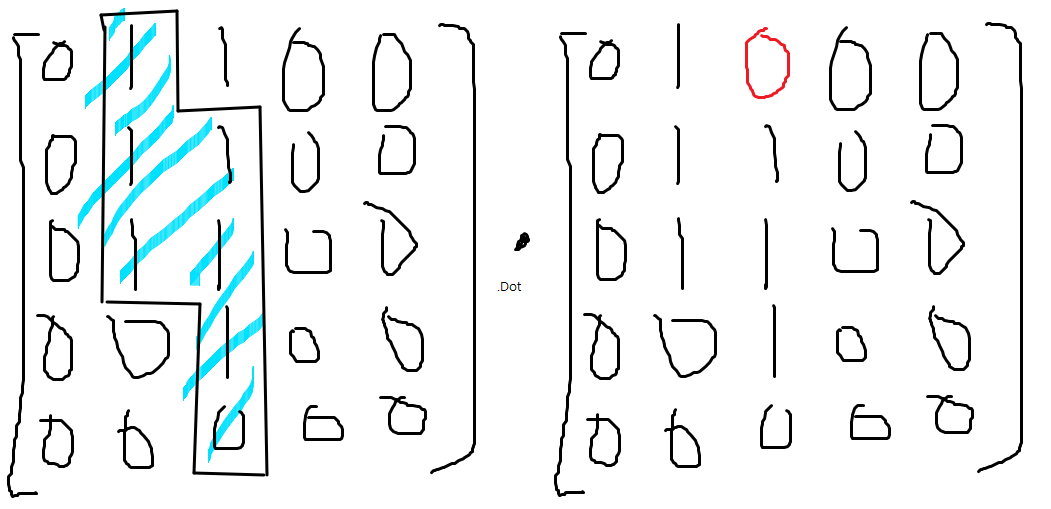

좌측이 prediction이고, 우측 GT라고 할떄 intersection은 빨강색 0 부분을 제외하고 1x1 + 1x1 + 1x1 + 1x1 + 1x1 + 1x1 = 6이 된다.  

In [48]:
dice_coeff

tensor(0.0477)

## dice_loss 

In [49]:
dice_loss = 1. - dice_coeff

In [50]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        
    def __call__(self, pred, target):
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        dice_loss = self._get_dice_loss(onehot_pred, onehot_target)
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return dice_loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target): # DSC 계산 함수 
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:      ## 배경만 존재할 경우(예측도 GT도 맞는 경우),
            set_sum = 2 * set_inter  ## DSC 값을 1로 만듬.
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):  ## DSC계산함수를 이용하여 CLass 별로 DSC를 계산함
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    def _get_batch_dice_coefficient(self, pred, target):   # BATCH 평균의 DSC 값 계산
        num_batch = pred.shape[0]   ## 1개 batch속에 담긴 데이터의 개수
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [51]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)  # dice_loss, dice_coefficient 출력

(tensor(0.9595), tensor(0.0405))

## 5. Loss function 구현 및 SGDM 최적화 적용하기

위에서 배운 DSC LOSS (Dice Loss)외에 Cross Entropy의 개념까지 적용하여 
Loss Functin을 만들어보자.

gt.shape = (4,3,3)이고

pred.shape = (4,3,3)일때 


1. nn.CrossEntropyLoss(reduction="mean")

    출력 : loss / (4 x3 x3)        ##   즉, 전체 파라미터 개수로 나눠줌 


2. nn.CrossEntropyLoss(reduction="none")          

    loss를 원소별 loss 값 그대로 출력 

    출력 : loss  (loss.shape = (4,3,3))

3. nn.CrossEntropyLoss(reduction="sum")

    loss를 원소별 loss 모두 합산하여 출력
    
    출력 : loss ( loss.shape = (batch_size, ) )
    
    따라서 이럴 경우에는 loss / batch_size로 나누어서 loss값 활용

In [52]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")
        
    def __call__(self, pred, target):
        loss1 = self.CE_loss(pred, target)  ## 출력 값과 타겟 값의 차이를 수치적으로 비교 (크로스 엔트로피)  , ONE HOT VECTOR 기능 내포됨
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)  ## 예측한 클래스와 정답 클래스를 DSC로 비교 (DICE LOSS)
        
        loss = loss1 + loss2          ## 크로스 엔트로피와 DICE LOSS를 합산하여 LOSS로 취급
        
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [54]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)

(tensor(2.3959, grad_fn=<AddBackward0>), tensor(0.0405))

In [55]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [56]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    criterion(predictions, targets)
    if index == 1:
        break

## 6. Semantic segmentation 학습을 위한 코드 작성하기

In [57]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
    losses = {}
    dice_coefficients = {}
    
    for phase in ["train", "val"]:  ## TRAIN과 VALIDATION을 한 EPOCH에서 동시에(순차적으로) 진행함
        running_loss = 0.0
        running_dice_coeff = 0.0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)
            
            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                loss, dice_coefficient = criterion(predictions, targets)
                
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()
            running_dice_coeff += dice_coefficient.item()
            
            if phase == "train":
                if index % 100 == 0:
                    text = f"{index}/{len(dataloaders[phase])}" + \
                            f" - Running Loss: {loss.item():.4f}" + \
                            f" - Running Dice: {dice_coefficient.item():.4f}" 
                    print(text)

        losses[phase] = running_loss / len(dataloaders[phase])
        dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
    return losses, dice_coefficients

In [58]:
from utils import save_model

In [60]:
data_dir = r"C:\Users\com\MEDICAL-DATASET-002\Segmentation"
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
# BATCH_SIZE = 2
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [61]:
num_epochs = 10
patience = 5
patience_count = 0
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coefficient = [], []
val_loss, val_dice_coefficient = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_dice_coefficient.append(dice_coefficients["train"])
    val_dice_coefficient.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")
    
    if (epoch > 3) and (dice_coefficients["val"] > best_score):  ## DSC 로 과적합 / BEST SCORE 판단
        best_epoch = epoch
        best_score = dice_coefficients["val"]
        save_model(model.state_dict(), f"model_{epoch:02d}.pth")
        patience_count = 0
        
    else : 
        patience_count += 1
        
        if patience_count >= patience:
            break;
        
        
        
print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

0/1243 - Running Loss: 2.8034 - Running Dice: 0.0410
100/1243 - Running Loss: 1.2766 - Running Dice: 0.0003
200/1243 - Running Loss: 1.0872 - Running Dice: 0.1338
300/1243 - Running Loss: 1.0901 - Running Dice: 0.1491
400/1243 - Running Loss: 1.0444 - Running Dice: 0.1049
500/1243 - Running Loss: 0.9948 - Running Dice: 0.1738
600/1243 - Running Loss: 0.9099 - Running Dice: 0.1887
700/1243 - Running Loss: 0.9283 - Running Dice: 0.2283
800/1243 - Running Loss: 0.8815 - Running Dice: 0.1987
900/1243 - Running Loss: 0.9124 - Running Dice: 0.2186
1000/1243 - Running Loss: 0.9386 - Running Dice: 0.1736
1100/1243 - Running Loss: 0.9186 - Running Dice: 0.1827
1200/1243 - Running Loss: 0.8979 - Running Dice: 0.1867
0/10 - Train Loss: 1.0493, Val Loss: 0.9284
0/10 - Train Dice Coeff: 0.1569, Val Dice Coeff: 0.2090
0/1243 - Running Loss: 0.9498 - Running Dice: 0.2325
100/1243 - Running Loss: 1.0353 - Running Dice: 0.1344
200/1243 - Running Loss: 0.9111 - Running Dice: 0.1634
300/1243 - Running Lo

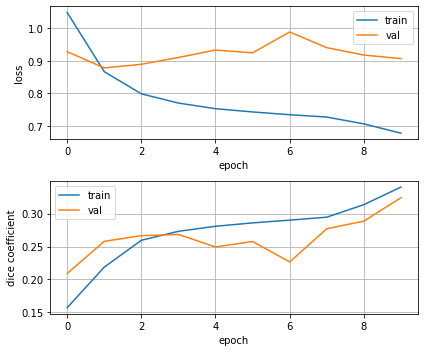

In [62]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_dice_coefficient, label="train")
plt.plot(val_dice_coefficient, label="val")
plt.xlabel("epoch")
plt.ylabel("dice coefficient")
plt.grid("on")
plt.legend()
plt.tight_layout()

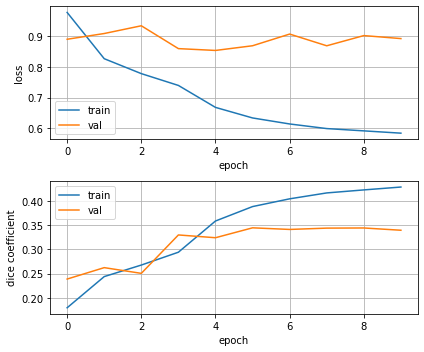

## 7. 모델 테스트 및 Morphological filtering 적용하기

In [58]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [60]:
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

In [62]:
ckpt_path = "./trained_model/model_05.pth"
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [63]:
def morpholocal_process(mask, num_classes, ksize=7):
    new_mask = mask.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(ksize, ksize))

    for class_index in range(1, num_classes):
        binary_mask = (mask == class_index).astype(np.uint8)
        closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        new_mask[closing.astype(np.bool_)] = class_index
    return new_mask

In [64]:
from utils import CLASS_ID_TO_RGB

In [65]:
def decode_segmap(mask, num_classes):
    mask_H, mask_W = mask.shape
    R_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    G_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    B_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)

    for class_index in range(1, num_classes):
        R_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][0]
        G_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][1]
        B_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][2]
    
    RGB_mask = cv2.merge((B_channel, G_channel, R_channel))
    return RGB_mask

In [72]:
from PIL import Image

In [78]:
@torch.no_grad()
def predict_segment(image, model, num_classes, device):
    PIL_image = Image.fromarray(image)
    tensor_image = transformer(PIL_image)
    tensor_image = tensor_image.to(device)

    pred_mask = model(torch.unsqueeze(tensor_image, dim=0))
    pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0)
    pred_mask = pred_mask.numpy()
    pred_mask = morpholocal_process(pred_mask, num_classes)
    rgb_mask = decode_segmap(pred_mask, num_classes)
    return rgb_mask

In [80]:
video_path = "../DATASET/Segmentation/video/test/ID00411637202309374271828.mp4"
cnt = 0
vidcap = cv2.VideoCapture(video_path)
while (vidcap.isOpened()):
    ret, frame = vidcap.read()

    if ret:
        rgb_mask = predict_segment(frame, model, NUM_CLASSES, DEVICE)
        rgb_mask = cv2.resize(rgb_mask, dsize=frame.shape[:2])
              
        alpha = 0.6
        blend = cv2.addWeighted(frame, alpha, rgb_mask, 1-alpha, 0)
        cv2.imshow('output', blend)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey(0)
    else:
        break
        
vidcap.release()
cv2.destroyAllWindows()